In [55]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

In [56]:
train = pl.read_csv("/kaggle/input/atmaCup#18_dataset/train_features.csv")
train = (
    train.with_columns(
        pl.col("ID").str.split_exact("_", n=1).struct.rename_fields(["sceneID", "offset"]).alias("fields")
    )
    .unnest("fields")
    .with_columns(pl.col("offset").cast(pl.Float32))
)
print(train.shape)
train.head()

(43371, 32)


ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,sceneID,offset
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f32
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…",320.0
"""00066be8e20318869c38c66be46663…",11.176292,0.279881,-11.625697,-44.0,0.0,false,0.0,false,"""drive""",false,true,4.970268,-0.007936,0.005028,10.350489,-0.032374,-0.020701,15.770054,0.084073,0.008645,21.132415,0.391343,0.036335,26.316489,0.843124,0.065,31.383814,1.42507,0.073083,"""00066be8e20318869c38c66be46663…",420.0
"""00066be8e20318869c38c66be46663…",10.472548,0.231099,-2.985105,-132.0,0.0,false,0.18,true,"""drive""",false,false,4.815701,-0.000813,0.017577,10.153522,-0.0278,0.026165,15.446539,-0.155987,0.040397,20.61816,-0.356932,0.058765,25.677387,-0.576985,0.102859,30.460033,-0.841894,0.152889,"""00066be8e20318869c38c66be46663…",520.0
"""000fb056f97572d384bae4f5fc1e0f…",6.055565,-0.117775,7.632668,173.0,0.0,false,0.0,false,"""drive""",false,false,2.812608,0.033731,0.0059,5.975378,0.137848,0.01621,9.186793,0.322997,0.031626,12.37311,0.603145,0.031858,15.703514,0.960717,0.043479,19.311182,1.374655,0.058754,"""000fb056f97572d384bae4f5fc1e0f…",120.0
"""000fb056f97572d384bae4f5fc1e0f…",3.316744,1.276733,-31.725477,-114.0,0.0,false,0.255,true,"""drive""",false,false,1.55186,-0.041849,-0.008847,3.675162,-0.125189,-0.013725,6.113567,-0.239161,-0.012887,8.770783,-0.381813,-0.003898,11.619313,-0.554488,0.011393,14.657048,-0.7788,0.044243,"""000fb056f97572d384bae4f5fc1e0f…",20.0


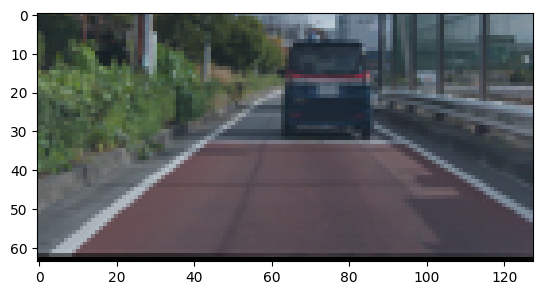

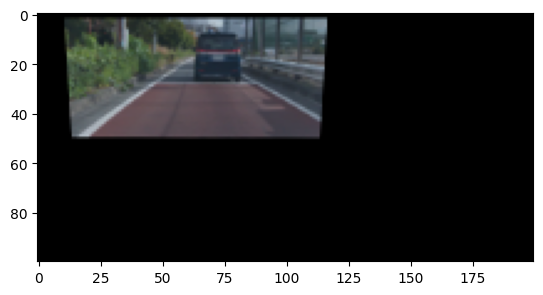

In [57]:
# カメラの内部パラメータ行列
K = np.array([[226.16438356, 0.0, 63.62426614], [0.0, 224.82352941, 11.76], [0.0, 0.0, 1.0]])

# 内部パラメータの逆行列
K_inv = np.linalg.inv(K)

# カメラの外部パラメータ（回転行列 R と並進ベクトル t）
# カメラの設置高さ（メートル）
h = 1.22

# カメラのピッチ角（下向きの角度、ラジアン）
theta_pitch = np.deg2rad(15)  # 15 度下向き

# 回転行列（x 軸周りの回転）
R_x = np.array(
    [[1, 0, 0], [0, np.cos(theta_pitch), -np.sin(theta_pitch)], [0, np.sin(theta_pitch), np.cos(theta_pitch)]]
)

# カメラの回転行列（ここでは y 軸周りの回転はないと仮定）
R = R_x

# 並進ベクトル（カメラの位置）
t = np.array([[0], [0], [h]])  # カメラは原点から高さ h の位置にあると仮定

# 地面平面はワールド座標系で z = 0 とする


# ホモグラフィ行列を計算する関数
def compute_homography(K, K_inv, R, t):
    # 回転行列の第1、第2列を取得
    r1 = R[:, 0].reshape(3, 1)
    r2 = R[:, 1].reshape(3, 1)
    # 並進ベクトル
    t = t.reshape(3, 1)
    # ホモグラフィ行列を計算
    H = K @ np.hstack([r1, r2, t]) @ K_inv
    return H


# ホモグラフィ行列を計算
H = compute_homography(K, K_inv, R, t)

p = 1  # ここで p をお好みの値に設定してください

# スケーリング行列を作成
S = np.array([[p, 0, 0], [0, p, 0], [0, 0, 1]])

# ホモグラフィ行列にスケーリングを適用
H_scaled = S @ H

# 出力画像のサイズを設定（必要に応じて調整）
# 例えば、横方向 10 メートル、縦方向 20 メートルを表示したい場合
output_width = int(200 * p)  # 10 メートル分のピクセル数
output_height = int(100 * p)  # 20 メートル分のピクセル数

# 画像を読み込み
ID = train["ID"][0]
path = os.path.join("/kaggle/input/atmaCup#18_dataset", "images", ID, "image_t.png")
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 画像サイズ
height, width = image.shape[:2]

# 画像を変換
warped_image = cv2.warpPerspective(image, H_scaled, (output_width, output_height))

# 結果を表示
plt.imshow(image)
plt.show()
plt.imshow(warped_image)
plt.show()


In [58]:
print(f"{H=}\n{H_scaled=}\n{R=}\n{t=}")

H=array([[1.00000000e+00, 7.32448772e-02, 1.31359788e+01],
       [0.00000000e+00, 9.79464053e-01, 2.82870273e+00],
       [0.00000000e+00, 1.15120978e-03, 1.20646177e+00]])
H_scaled=array([[1.00000000e+00, 7.32448772e-02, 1.31359788e+01],
       [0.00000000e+00, 9.79464053e-01, 2.82870273e+00],
       [0.00000000e+00, 1.15120978e-03, 1.20646177e+00]])
R=array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.96592583, -0.25881905],
       [ 0.        ,  0.25881905,  0.96592583]])
t=array([[0.  ],
       [0.  ],
       [1.22]])


In [ ]:
print(f"{H=}\n{H_scaled=}\n{R=}\n{t=}")

H=array([[1.00000000e+00, 7.32448772e-02, 1.31359788e+01],
       [0.00000000e+00, 9.79464053e-01, 2.82870273e+00],
       [0.00000000e+00, 1.15120978e-03, 1.20646177e+00]])
H_scaled=array([[1.00000000e+00, 7.32448772e-02, 1.31359788e+01],
       [0.00000000e+00, 9.79464053e-01, 2.82870273e+00],
       [0.00000000e+00, 1.15120978e-03, 1.20646177e+00]])
R=array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.96592583, -0.25881905],
       [ 0.        ,  0.25881905,  0.96592583]])
t=array([[0.  ],
       [0.  ],
       [1.22]])
